In [ ]:
!pip install transformers torch

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from transformers import AutoTokenizer, EsmForMaskedLM
from tqdm import tqdm
from peft import LoraConfig, get_peft_model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import random
import scipy.stats as stats
from scipy.stats import spearmanr

In [ ]:
#initializing model

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name).to(device)

model.eval()

Using cpu device


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=1

In [ ]:
# uniprot 043186 CRX_HUMAN

crx_sequence = """
MMAYMNPGPHYSVNALALSGPSVDLMHQAVPYPSAPRKQRRERTTFTRSQLEELEALFAKTQYPDVYAREEVALKINLPESRVQVWFKNRRAKCRQQRQQQKQQQQPPGGQAKARPAKRKAGTSPRPSTDVCPDPLGISDSYSPPLPGPSGSPTTAVATVSIWSPASESPLPEAQRAGLVASGPSLTSAPYAMTYAPASAFCSSPSAYGSPSSYFSGLDPYLSPMVPQLGGPALSPLSGPSVGPSLAQSPTSLSGQSYGAYSPVDSLEFKDPTGTWKFTYNPMDPLDYKDQSAWKFQIL
""".replace('\n', '').replace(' ', '')
print(crx_sequence)
print(len(crx_sequence))

MMAYMNPGPHYSVNALALSGPSVDLMHQAVPYPSAPRKQRRERTTFTRSQLEELEALFAKTQYPDVYAREEVALKINLPESRVQVWFKNRRAKCRQQRQQQKQQQQPPGGQAKARPAKRKAGTSPRPSTDVCPDPLGISDSYSPPLPGPSGSPTTAVATVSIWSPASESPLPEAQRAGLVASGPSLTSAPYAMTYAPASAFCSSPSAYGSPSSYFSGLDPYLSPMVPQLGGPALSPLSGPSVGPSLAQSPTSLSGQSYGAYSPVDSLEFKDPTGTWKFTYNPMDPLDYKDQSAWKFQIL
299


In [ ]:
inputs = tokenizer(crx_sequence, return_tensors="pt", add_special_tokens=True)

In [ ]:
inputs

{'input_ids': tensor([[ 0, 20, 20,  5, 19, 20, 17, 14,  6, 14, 21, 19,  8,  7, 17,  5,  4,  5,
          4,  8,  6, 14,  8,  7, 13,  4, 20, 21, 16,  5,  7, 14, 19, 14,  8,  5,
         14, 10, 15, 16, 10, 10,  9, 10, 11, 11, 18, 11, 10,  8, 16,  4,  9,  9,
          4,  9,  5,  4, 18,  5, 15, 11, 16, 19, 14, 13,  7, 19,  5, 10,  9,  9,
          7,  5,  4, 15, 12, 17,  4, 14,  9,  8, 10,  7, 16,  7, 22, 18, 15, 17,
         10, 10,  5, 15, 23, 10, 16, 16, 10, 16, 16, 16, 15, 16, 16, 16, 16, 14,
         14,  6,  6, 16,  5, 15,  5, 10, 14,  5, 15, 10, 15,  5,  6, 11,  8, 14,
         10, 14,  8, 11, 13,  7, 23, 14, 13, 14,  4,  6, 12,  8, 13,  8, 19,  8,
         14, 14,  4, 14,  6, 14,  8,  6,  8, 14, 11, 11,  5,  7,  5, 11,  7,  8,
         12, 22,  8, 14,  5,  8,  9,  8, 14,  4, 14,  9,  5, 16, 10,  5,  6,  4,
          7,  5,  8,  6, 14,  8,  4, 11,  8,  5, 14, 19,  5, 20, 11, 19,  5, 14,
          5,  8,  5, 18, 23,  8,  8, 14,  8,  5, 19,  6,  8, 14,  8,  8, 19, 18,
          8,  

In [ ]:
#Getting predictions from the model
with torch.no_grad():  # do not compute gradients when performing inference
    outputs = model(**inputs)
    logits = outputs.logits

In [ ]:
print(outputs[0])
print(logits[0,0])

tensor([[[ 20.6570,  -6.2713,   1.7439,  ..., -14.3668, -15.0417,  -6.3211],
         [ -4.6631, -14.5529,  -9.5724,  ..., -15.2000, -16.0580, -14.5729],
         [-13.8057, -16.2113, -11.6616,  ..., -15.5860, -15.6080, -16.2072],
         ...,
         [-12.5962, -18.5067, -11.6882,  ..., -16.2350, -16.0803, -18.4449],
         [-13.0611, -15.9158, -10.9855,  ..., -16.0570, -15.8109, -15.9137],
         [  3.1729,  -5.9022,  24.6123,  ..., -14.5565, -14.8621,  -5.9440]]])
tensor([ 20.6570,  -6.2713,   1.7439,  -6.3363,  -0.5524,  -0.1750,  -0.8136,
         -0.4946,   0.7192,  -1.1769,  -1.3694,  -0.7098,  -1.8136,  -1.0738,
         -1.1406,  -1.7424,  -1.0069,  -0.8062,  -2.5772,  -1.7114,   2.3582,
         -1.6349,  -3.8860,  -2.3743,  -8.2909,  -8.6771,  -4.9522,  -9.3040,
        -15.0916, -14.5790, -14.3668, -15.0417,  -6.3211])


In [ ]:
print(logits.shape)

torch.Size([1, 301, 33])


In [ ]:
vocab = tokenizer.get_vocab() # possible entries for each position
input_ids = inputs['input_ids'] # tensor matrix of tokenized inputs
log_probs = torch.log_softmax(logits, dim=-1) #log probability

In [ ]:
print(log_probs.shape)
log_probs

torch.Size([1, 301, 33])


tensor([[[  0.0000, -26.9282, -18.9130,  ..., -35.0238, -35.6986, -26.9780],
         [-11.9261, -21.8160, -16.8354,  ..., -22.4630, -23.3210, -21.8359],
         [-17.5872, -19.9928, -15.4431,  ..., -19.3675, -19.3895, -19.9887],
         ...,
         [-15.9230, -21.8335, -15.0150,  ..., -19.5618, -19.4071, -21.7717],
         [-17.9039, -20.7586, -15.8283,  ..., -20.8998, -20.6537, -20.7565],
         [-21.4394, -30.5145,   0.0000,  ..., -39.1688, -39.4744, -30.5564]]])

In [ ]:
print(vocab)

{'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}


In [ ]:
input_ids.size()

torch.Size([1, 301])

In [ ]:
log_probs[0,0] #log-probability that 0 position has any of the letters from the vocabulary

tensor([  0.0000, -26.9282, -18.9130, -26.9932, -21.2093, -20.8320, -21.4706,
        -21.1515, -19.9378, -21.8339, -22.0264, -21.3667, -22.4706, -21.7307,
        -21.7975, -22.3994, -21.6638, -21.4631, -23.2341, -22.3684, -18.2988,
        -22.2919, -24.5429, -23.0312, -28.9479, -29.3340, -25.6092, -29.9609,
        -35.7486, -35.2359, -35.0238, -35.6986, -26.9780])

In [ ]:
print(torch.arange(input_ids.size(1)))
print(input_ids.size(1))
print(input_ids[0])

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [ ]:
# tensor with length = sequence length
# why 2 larger?

ref_log_probs = log_probs[0, torch.arange(input_ids.size(1)), input_ids[0]]

print(ref_log_probs)

print(ref_log_probs.shape)
print(log_probs.shape)

tensor([ 0.0000e+00, -6.1820e-03, -6.1626e-01, -2.8478e-01, -4.9924e-01,
        -6.9610e-01, -7.9018e-01, -1.7794e-01, -4.8641e-01, -3.4257e-01,
        -9.7779e-01, -6.3414e-01, -2.4741e-01, -6.7637e-01, -8.4276e-01,
        -4.2372e-01, -3.7287e-01, -2.6504e-01, -3.0477e-01, -2.7124e-01,
        -2.8904e-01, -1.7627e-01, -2.2910e-01, -6.0265e-01, -7.9380e-01,
        -2.7878e-01, -1.0323e+00, -7.9990e-01, -4.5580e-01, -2.4751e-01,
        -6.1526e-01, -2.2825e-01, -1.6022e+00, -2.1507e-01, -2.3624e-01,
        -2.3301e-01, -9.9457e-02, -1.1600e-01, -8.2869e-02, -1.2551e-01,
        -1.1254e-02, -4.3796e-03, -4.9895e-01, -1.5436e-04, -4.6826e-04,
        -6.6029e-02, -1.0770e-02, -3.2140e-02, -2.7119e-01, -2.7300e-01,
        -1.5867e-03, -2.7285e-02, -4.9606e-02, -1.8887e-01, -4.0237e-04,
        -3.9045e-03, -2.0255e-01, -3.3155e-02, -1.0226e-02, -1.3194e-01,
        -1.5158e-01, -3.6186e-01, -1.8408e-01, -3.7743e-02, -8.5368e-03,
        -6.7023e-03, -2.1577e-01, -1.7684e-01, -6.1

In [ ]:
# processing

ref_log_probs_unsqueezed = ref_log_probs.unsqueeze(1)
print(ref_log_probs_unsqueezed.shape)

torch.Size([301, 1])


In [ ]:
print(log_probs[0,1])
print(log_probs[0,2])
print(ref_log_probs_unsqueezed)


tensor([-1.1926e+01, -2.1816e+01, -1.6835e+01, -2.1797e+01, -7.7313e+00,
        -7.2168e+00, -7.9937e+00, -7.9946e+00, -7.2505e+00, -8.6630e+00,
        -8.3853e+00, -7.7323e+00, -8.4981e+00, -8.3167e+00, -7.3122e+00,
        -8.5375e+00, -8.2761e+00, -7.9737e+00, -8.5034e+00, -8.1823e+00,
        -6.1820e-03, -8.5026e+00, -1.0581e+01, -9.8979e+00, -9.3444e+00,
        -1.6067e+01, -1.6753e+01, -1.7264e+01, -2.3113e+01, -2.3793e+01,
        -2.2463e+01, -2.3321e+01, -2.1836e+01])
tensor([-17.5872, -19.9928, -15.4431, -20.0437,  -3.9516,  -2.2855,  -4.2819,
         -4.5856,  -2.6118,  -2.8403,  -5.4396,  -3.9427,  -5.4993,  -2.8904,
         -3.9000,  -5.1950,  -4.1978,  -3.9946,  -4.6687,  -3.8871,  -0.6163,
         -5.0669,  -5.9068,  -6.3548, -11.6607, -15.2658, -15.5989, -15.8172,
        -18.9243, -19.7128, -19.3675, -19.3895, -19.9887])
tensor([[ 0.0000e+00],
        [-6.1820e-03],
        [-6.1626e-01],
        [-2.8478e-01],
        [-4.9924e-01],
        [-6.9610e-01],
     

In [ ]:
# log-likelihood ratio matrix... log(a/b) = log(a) - log(b)

llr_matrix = log_probs[0] - ref_log_probs_unsqueezed

In [ ]:
# the input tensor had 0 -> <cls> in the first entry and 2 -> <eos> in the last entry

print(llr_matrix.shape)
llr_matrix[3]

torch.Size([301, 33])


tensor([-16.4927, -20.3549, -15.9667, -20.3878,  -4.7991,   0.0000,  -3.8498,
         -5.0809,  -2.9282,  -3.5297,  -5.6295,  -4.4322,  -6.2016,  -2.3953,
         -3.9625,  -5.4327,  -4.4417,  -3.7912,  -5.2107,  -4.3869,  -4.1743,
         -4.7837,  -7.1346,  -6.1687, -12.3711, -15.4825, -15.8749, -16.6281,
        -19.0600, -19.3194, -19.1719, -19.6330, -20.3498])

In [ ]:
llr_matrix_clean = llr_matrix[1:-1, :] # drop the first and last rows
print(llr_matrix_clean.shape)
llr_matrix_clean

torch.Size([299, 33])


tensor([[-11.9199, -21.8098, -16.8292,  ..., -22.4568, -23.3148, -21.8298],
        [-16.9710, -19.3766, -14.8269,  ..., -18.7512, -18.7733, -19.3725],
        [-16.4927, -20.3549, -15.9667,  ..., -19.1719, -19.6330, -20.3498],
        ...,
        [-14.9048, -21.3627, -15.3298,  ..., -19.0628, -19.4100, -21.3068],
        [-14.8841, -20.7946, -13.9761,  ..., -18.5230, -18.3683, -20.7328],
        [-17.8073, -20.6620, -15.7317,  ..., -20.8032, -20.5571, -20.6598]])

In [ ]:
# only get the amino acid tokens
# what order should these be in?
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_token_ids = [tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids]

#aa_token_ids = sorted(aa_token_ids)

aa_token_ids

[5, 23, 13, 9, 18, 6, 21, 12, 15, 4, 20, 17, 14, 16, 10, 8, 11, 7, 22, 19]

In [ ]:
#new matrix with just amino acids
llr_matrix_aa_only = llr_matrix_clean[:, aa_token_ids]
print(f"\nLLR matrix (amino acids only) shape: {llr_matrix_aa_only.shape}")


LLR matrix (amino acids only) shape: torch.Size([299, 20])


In [ ]:
llr_matrix_aa_only[290:,:]

tensor([[-3.0473, -5.3472, -3.4568, -3.8225, -4.1399, -4.4140, -3.8228, -4.4787,
         -5.5494, -3.1697, -4.4958, -3.9384, -0.2541,  0.0000, -5.7599, -2.3375,
         -2.7838, -4.2128, -6.8589, -4.1901],
        [-3.9586, -7.0371, -4.7481, -4.9568, -7.1657, -4.8572, -6.6120, -6.3501,
         -6.7977, -5.0216, -5.3055, -4.5834, -5.2894, -5.2185, -7.1890,  0.0000,
         -2.6589, -5.5941, -8.8738, -7.1646],
        [ 0.0000, -5.6575, -3.3934, -4.1971, -5.3077, -3.5618, -5.2717, -5.3530,
         -5.2050, -4.4090, -5.3175, -3.8170, -4.7693, -4.5986, -6.4045, -3.0663,
         -3.7374, -4.5587, -7.9853, -4.7967],
        [-3.5646, -4.9916, -4.1816, -3.9534, -2.9412, -3.3760, -4.7398, -4.7578,
         -5.4993, -3.2923, -4.2888, -4.2681, -3.7552, -3.8168, -5.2454, -3.2890,
         -3.8927, -4.3303,  0.0000, -2.7374],
        [-6.5832, -8.3232, -5.6469, -6.3896, -7.5073, -5.6651, -6.3165, -8.4306,
          0.0000, -7.0636, -7.5141, -5.2384, -6.2756, -5.3757, -4.6770, -5.3782,
      

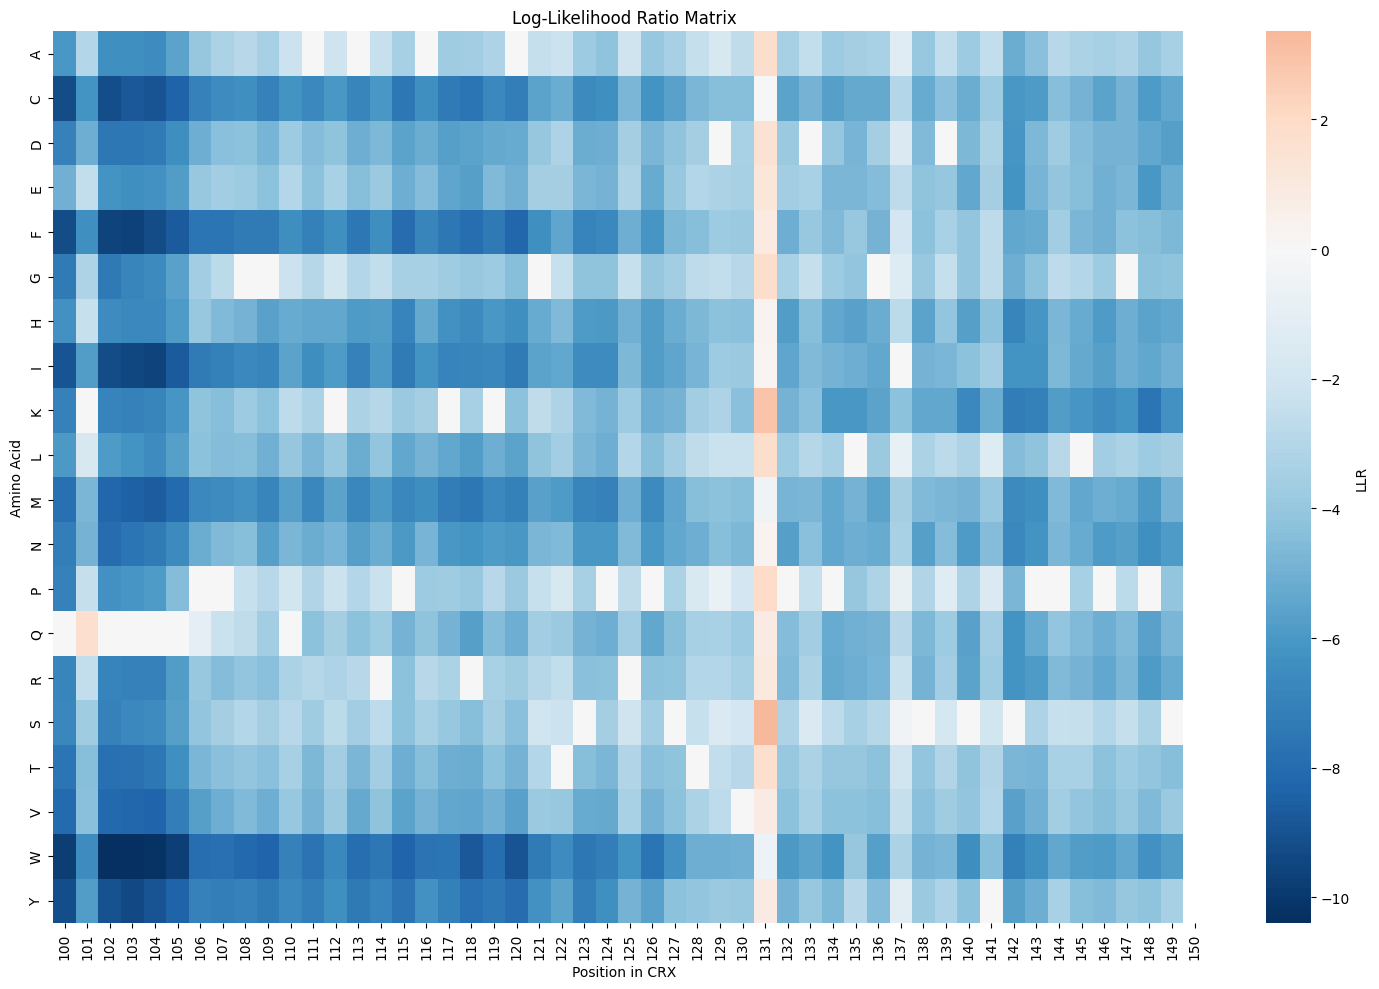

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(llr_matrix_aa_only[100:150,:].T,
            xticklabels=range(100, 151),
            yticklabels=list(amino_acids),
            cmap='RdBu_r', # change to white to dark red
            center=0,
            cbar_kws={'label': 'LLR'})
plt.xlabel('Position in CRX')
plt.ylabel('Amino Acid')
plt.title('Log-Likelihood Ratio Matrix')
plt.tight_layout()
#plt.savefig('crx_llr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
crx_sequence[100:151]

'QKQQQQPPGGQAKARPAKRKAGTSPRPSTDVCPDPLGISDSYSPPLPGPSG'

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(llr_matrix_aa_only[100:151,:].T,
            xticklabels=range(1,300),
            yticklabels=list(amino_acids),
            cmap='RdBu_r', # change to white to dark red
            center=0,
            cbar_kws={'label': 'LLR'})
plt.xlabel('Position in CRX')
plt.ylabel('Amino Acid')
plt.title('Log-Likelihood Ratio Matrix')
plt.tight_layout()
#plt.savefig('crx_llr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

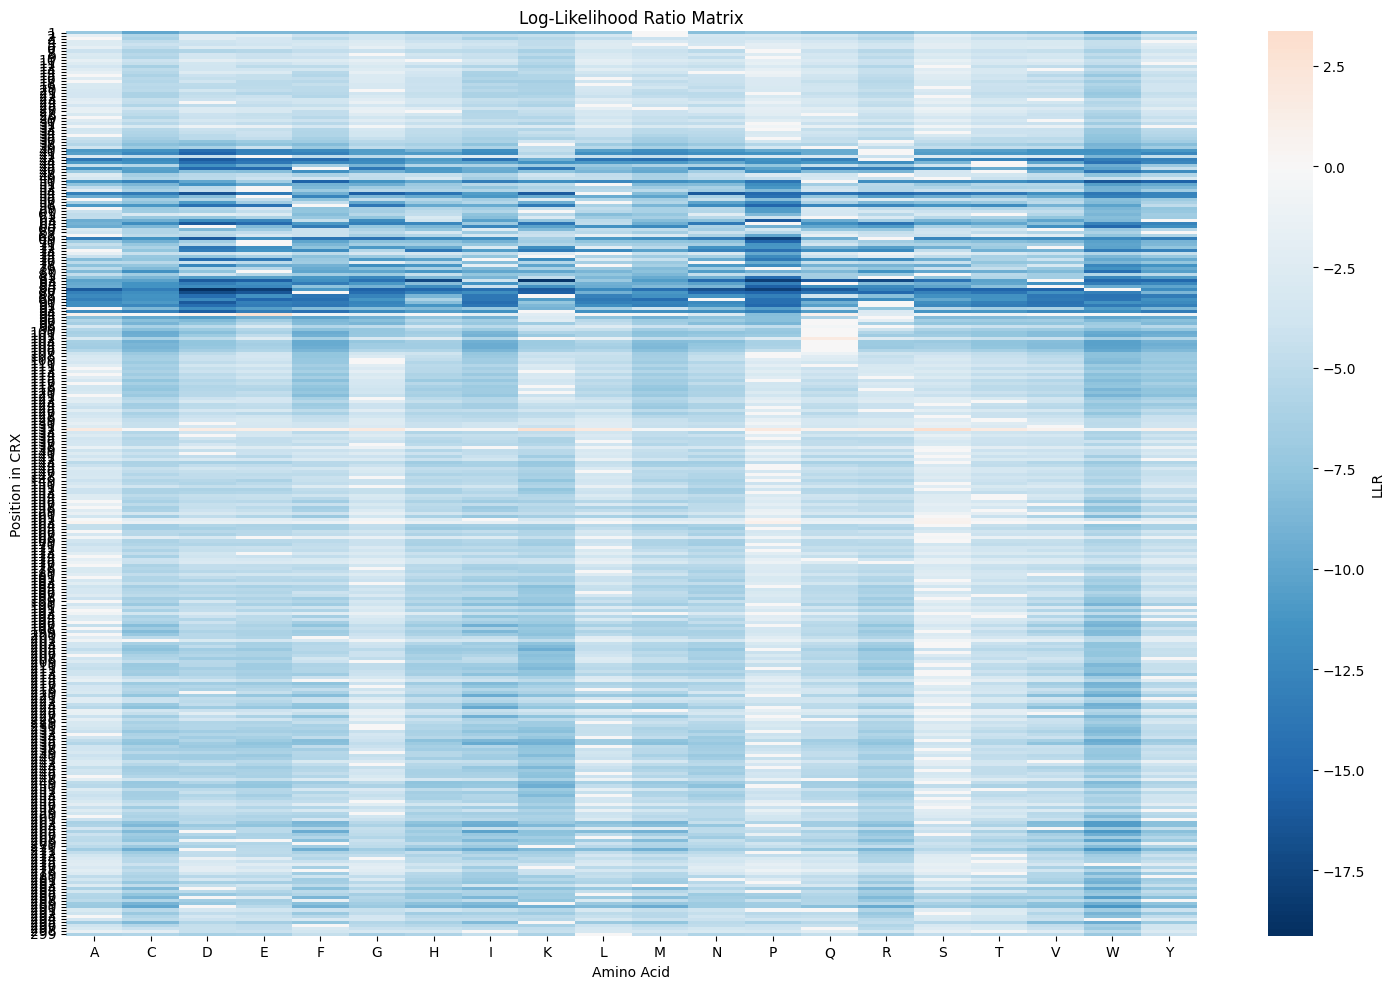

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(llr_matrix_aa_only,
            xticklabels=list(amino_acids),
            yticklabels=range(1, 300),
            cmap='RdBu_r', # change to white to dark red
            center=0,
            cbar_kws={'label': 'LLR'})
plt.xlabel('Amino Acid')
plt.ylabel('Position in CRX')
plt.title('Log-Likelihood Ratio Matrix')
plt.tight_layout()
#plt.savefig('crx_llr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(ref_log_probs_unsqueezed)

tensor([[ 0.0000e+00],
        [-6.1820e-03],
        [-6.1626e-01],
        [-2.8478e-01],
        [-4.9924e-01],
        [-6.9610e-01],
        [-7.9018e-01],
        [-1.7794e-01],
        [-4.8641e-01],
        [-3.4257e-01],
        [-9.7779e-01],
        [-6.3414e-01],
        [-2.4741e-01],
        [-6.7637e-01],
        [-8.4276e-01],
        [-4.2372e-01],
        [-3.7287e-01],
        [-2.6504e-01],
        [-3.0477e-01],
        [-2.7124e-01],
        [-2.8904e-01],
        [-1.7627e-01],
        [-2.2910e-01],
        [-6.0265e-01],
        [-7.9380e-01],
        [-2.7878e-01],
        [-1.0323e+00],
        [-7.9990e-01],
        [-4.5580e-01],
        [-2.4751e-01],
        [-6.1526e-01],
        [-2.2825e-01],
        [-1.6022e+00],
        [-2.1507e-01],
        [-2.3624e-01],
        [-2.3301e-01],
        [-9.9457e-02],
        [-1.1600e-01],
        [-8.2869e-02],
        [-1.2551e-01],
        [-1.1254e-02],
        [-4.3796e-03],
        [-4.9895e-01],
        [-1

In [ ]:
len(log_probs[0,1:-1])

299

In [ ]:
with open("output.txt","w") as f:
  print(log_probs[0,1:-1].tolist(), file=f)

In [ ]:
import pickle

In [ ]:
with open('log_probs.pkl', 'wb') as f:
    pickle.dump(log_probs[0], f)

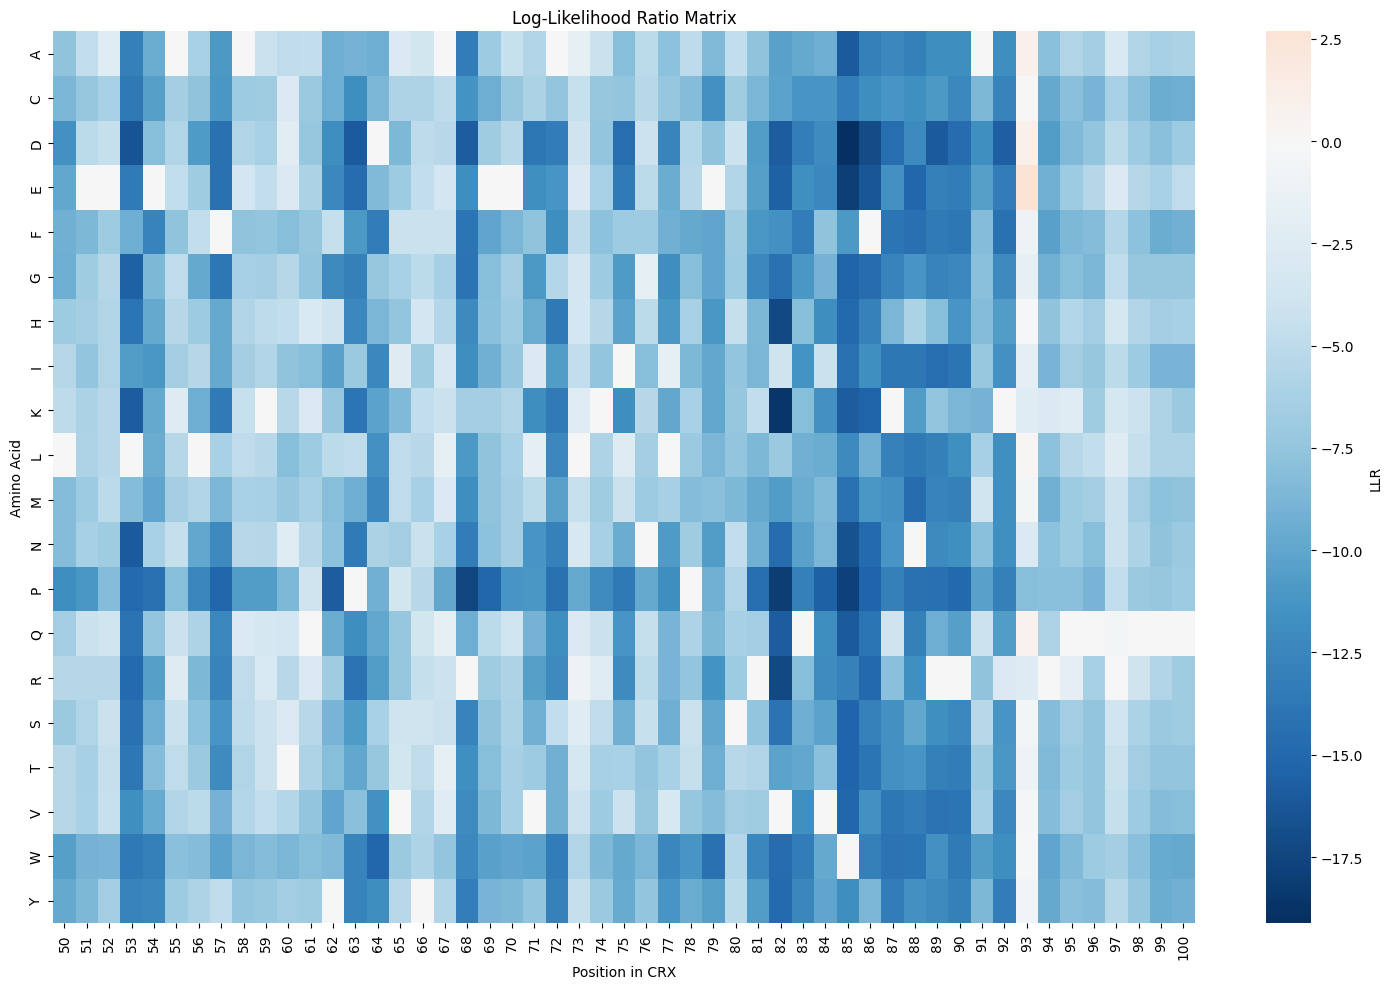

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(llr_matrix_aa_only[50:101,:].T,
            xticklabels=range(50, 101),
            yticklabels=list(amino_acids),
            cmap='RdBu_r', # change to white to dark red
            center=0,
            cbar_kws={'label': 'LLR'})
plt.xlabel('Position in CRX')
plt.ylabel('Amino Acid')
plt.title('Log-Likelihood Ratio Matrix')
plt.tight_layout()
#plt.savefig('crx_llr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()